# Self-Organizing Map on the Iris Dataset

In [2]:
from minisom import MiniSom

from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler

import math
import numpy as np

import matplotlib.pyplot as plt

## Preparing the data

In [3]:
iris = load_iris()
features = iris.data
labels = iris.target

print(f'features[0] ')

features[0] 


## Normalizing the data

In [4]:
sc = MinMaxScaler(feature_range = (0,1))
features = sc.fit_transform(features)

## Building the SOM

The author of the Minisom package recommend a map size of 5 * sqrt(number of samples) 

In [138]:
sigma = 1.5
lr = 0.5
n_features = features.shape[1]
n_samples = features.shape[0]

map_size = 5 * math.sqrt(n_samples)
map_height = map_width = math.ceil(math.sqrt(map_size))


print(f'(map_height, map_width) = ({map_height}, {map_width})')
print(f'Number of features: {n_features}')

(map_height, map_width) = (8, 8)
Number of features: 4


In [6]:
som = MiniSom(x=map_height, y=map_width, input_len=n_features, sigma=sigma, learning_rate=lr, 
              neighborhood_function='gaussian', random_seed=123)
 
som.pca_weights_init(features)
som.train(data=features, num_iteration=1000, verbose=True)  # random training

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.06627848868800729


## Results

The distance map is a 2D array (12x12) where each element represents the average distance between a neuron and its neighbors.

In [7]:
print('-------------\nDistance Map\n------------')
print(f'Shape: {som.distance_map().shape}')
print(f'First Line: {som.distance_map().T[0]}')

-------------
Distance Map
------------
Shape: (8, 8)
First Line: [0.08193295 0.16554244 0.17720363 0.58759007 0.66732804 0.43138852
 0.35650207 0.18395191]


The frequencies is a 2D array where each neuron at (x,y) is the number of time the neuron was winner
E.g: neuron located at (2, 5) may contains 7 

In [8]:
frequencies = som.activation_response(features)
print(f'Frequencies:\n {np.array(frequencies, np.uint)}')

Frequencies:
 [[3 1 3 2 3 3 1 0]
 [4 3 4 2 7 0 1 3]
 [1 3 2 1 0 2 4 1]
 [4 2 1 0 4 4 3 3]
 [0 0 0 2 2 3 1 0]
 [5 4 3 1 3 1 3 4]
 [1 2 0 3 1 3 3 2]
 [3 4 2 3 6 3 2 5]]


## Visualzing the results
We can cleary dsitinguish the clusters:
* Setosa: red circles
* Versicolor:  green squares
* Virginica: blue triangles 

In [9]:
print(iris.target_names)

['setosa' 'versicolor' 'virginica']


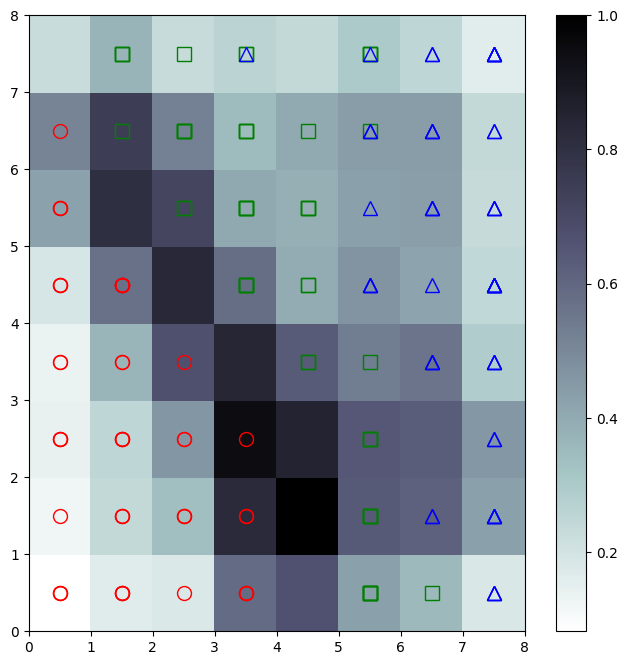

In [133]:
plt.figure(figsize=(map_height, map_width))

# plot U-matrix
u_matrix = som.distance_map().T
plt.pcolor(u_matrix, cmap='bone_r')
plt.colorbar()

# plot markers
markers = ['o', 's', '^']   # 'setosa', 'versicolor' 'virginica'
colors = ['r', 'g', 'b']
for feature, label in zip(features, labels):
    w = som.winner(feature)
    plt.plot(w[0] + 0.5, w[1] + 0.5, 
        markers[label], markeredgecolor = colors[label], 
        markerfacecolor = 'None', markersize = 10, markeredgewidth = 1)

plt.show()

## Plotting the clusters
On our distance map, the light shades represent the clusters whereas the dark ones represents the division of the clusters. 
However, some people plot their distance map the other way where dark shades represents clusters.

In [47]:
def plot_distance_map(ax, fig):
    """Plot the distance map"""
    p = ax.pcolor(som.distance_map().T, cmap='bone_r') # cmap='Blues'
    # ax.colorbar()
    fig.colorbar(p, ax=ax)

In [84]:
def plot_clusters_scatter(ax):
    """
    Create a scatter plot of the winning neurons. 
    Each neuron is assigned the color of the cluster it belongs to.
    """ 
    # Get the winning neuron coordinates for each sample 
    # The coordinates are transformed into an array for the scatter plot: (1,1) => [1,1]
    winning_neurons = np.array([som.winner(x) for x in features])

    # Add a random offset to avoid overlaps between points within the same cell
    offset = np.random.uniform(low=-0.4, high=0.4, size=(len(features), 2))
    winning_neurons = winning_neurons + offset

    # Define the colors based on the labels
    colors = ['#ff0400', 'g', '#e88325']
    label_colors = [colors[label] for label in labels]

    # Create the scatter plot
    # 1st column represent x and second, y coordinate
    ax.scatter(winning_neurons[:,0], winning_neurons[:,1], s=10, c=label_colors)

In [113]:
def plot_clusters_markers(ax):
    """
    Plot the winning neurons as markers.
    Each marker is assigned the color of the cluster ir belongs to.
    """
    markers = ['o', 's', '^']
    colors = ['#ff0400', 'g', '#e88325']
    for i, feature in enumerate(features):
        w = som.winner(feature)
        ax.plot(w[0] + 0.5, w[1] + 0.5, 
            markers[labels[i]], markeredgecolor = colors[labels[i]], 
            markerfacecolor = 'None', markersize = 10, markeredgewidth = 1)
        
    # legend
    ax.legend(handles=[plt.Line2D([], [], color='#ff0400', marker='o', linestyle='None', label='Setosa'),
                    plt.Line2D([], [], color='green', marker='s', linestyle='None', label='Versicolor'),
                    plt.Line2D([], [], color='#e88325', marker='^', linestyle='None', label='Virginica')],
                    bbox_to_anchor=(1.5, 1.03))

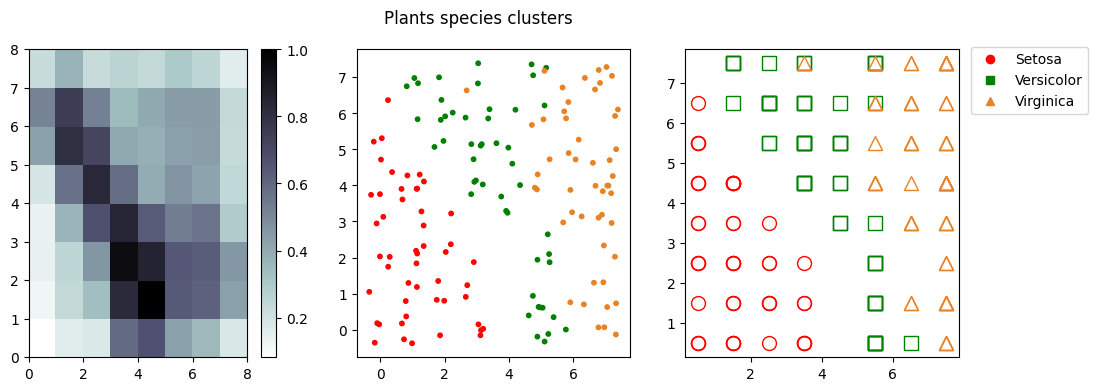

In [127]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

plot_distance_map(axes[0], fig)
plot_clusters_scatter(axes[1])
plot_clusters_markers(axes[2])

plt.suptitle("Plants species clusters")
plt.show()

## Most activated neurons

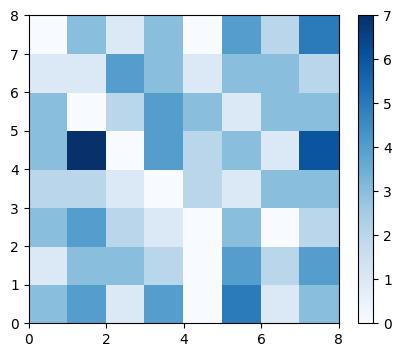

In [15]:
plt.figure(figsize=(5, 4))

frequencies = som.activation_response(features)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.show()

## References

* https://analyticsindiamag.com/beginners-guide-to-self-organizing-maps/
* https://medium.com/@abhinavr8/self-organizing-maps-ff5853a118d4